In [52]:
from ucimlrepo import fetch_ucirepo
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.metrics import Accuracy, Recall, Precision, AUC

In [53]:
# fetch dataset
german_credit_data = fetch_ucirepo(id=144)
# data (as pandas dataframes)
X = german_credit_data.data.features
y = german_credit_data.data.targets

# variable information
print(german_credit_data.variables)

# Preprocess the data:

categorical = X.select_dtypes(include=["object"]).columns.tolist()
numerical = X.select_dtypes(include=["int64"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OrdinalEncoder(), categorical),
        ("num", StandardScaler(), numerical),
    ]
)

# Divide the data into training set & testing set.
X_train, X_temp, y1_train, y1_temp = train_test_split(
    X, y, test_size=0.3, stratify=y
)

X_val, X_test, y1_val, y1_test = train_test_split(
    X_temp, y1_temp, test_size=0.5, stratify=y1_temp
)

y_train = (y1_train.values.ravel() == 1).astype(int)
y_test = (y1_test.values.ravel() == 1).astype(int)
y_val = (y1_val.values.ravel() == 1).astype(int)

preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
X_val_processed = preprocessor.transform(X_val)

           name     role         type     demographic  \
0    Attribute1  Feature  Categorical            None   
1    Attribute2  Feature      Integer            None   
2    Attribute3  Feature  Categorical            None   
3    Attribute4  Feature  Categorical            None   
4    Attribute5  Feature      Integer            None   
5    Attribute6  Feature  Categorical            None   
6    Attribute7  Feature  Categorical           Other   
7    Attribute8  Feature      Integer            None   
8    Attribute9  Feature  Categorical  Marital Status   
9   Attribute10  Feature  Categorical            None   
10  Attribute11  Feature      Integer            None   
11  Attribute12  Feature  Categorical            None   
12  Attribute13  Feature      Integer             Age   
13  Attribute14  Feature  Categorical            None   
14  Attribute15  Feature  Categorical           Other   
15  Attribute16  Feature      Integer            None   
16  Attribute17  Feature  Categ

In [54]:
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(X_train_processed, y_train)
y_pred = logistic_model.predict_proba(X_test_processed)
y_pred_train = logistic_model.predict_proba(X_train_processed)

print(f"Logistic Loss on Test set: {log_loss(y_test, y_pred)}")
print(f"Logistic Loss on Training set: {log_loss(y_train, y_pred_train)}")

Logistic Loss on Test set: 0.4404780979002955
Logistic Loss on Training set: 0.4803411276495641


/home/orisnow/python-venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.


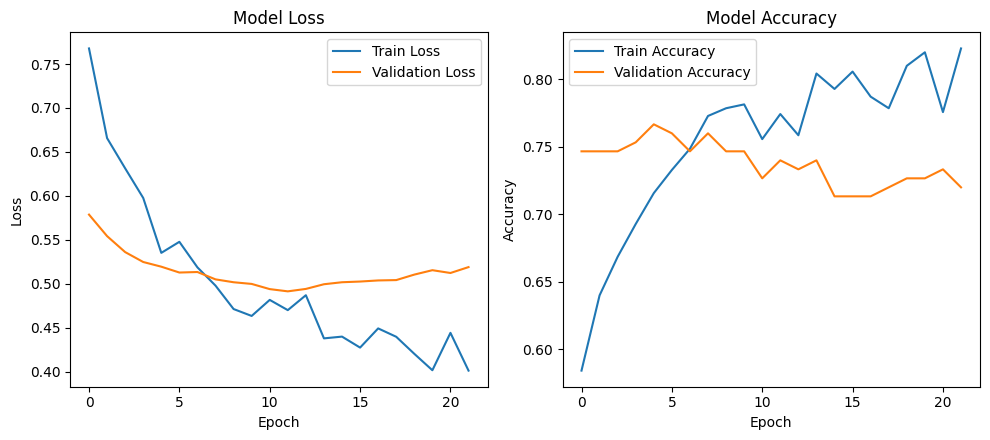

In [55]:
deep_learning_model = Sequential(
    [
        Dense(64, activation="relu", input_shape=(20,)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)

deep_learning_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)
history = deep_learning_model.fit(
    X_train_processed,
    y_train,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping],
    epochs=1000,
    batch_size=32,
    verbose=0,
)

plt.figure(figsize=(10, 4.5))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
# Hyperparameters:

# Learning Rate:
learning_rates = [10 ** (-x - 1) for x in range(6)]

results = []

for learning_rate in learning_rates:
    model = Sequential(
        [
            Dense(64, activation="relu", input_shape=(20,)),
            BatchNormalization(),
            Dropout(0.2),
            Dense(32, activation="relu"),
            BatchNormalization(),
            Dropout(0.2),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    history = model.fit(
        X_train_processed,
        y_train,
        validation_data=(X_val_processed, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0,
    )

    y_pred = (model.predict(X_test_processed).ravel() >= 0.5).astype(int)
    acc_calculator = Accuracy()
    acc_calculator.update_state(y_test, y_pred)
    acc = acc_calculator.result().numpy()

    results.append(
        {
            "learning_rate": learning_rate,
            "units": 32,
            "test_acc": acc,
        }
    )

    print("-" * 40)
    print(f"Learning Rate: {learning_rate}")
    print(f"Units: {32}")
    print(f"Accuracy on test set: {acc}")
    print("-" * 40)

# Choose the model with the highest acc
best_lr = max(results, key=lambda x: x["test_acc"])["learning_rate"]
results.clear()

# Units in model
units = [8, 16, 32, 64, 128]
for unit in units:
    learning_rate = best_lr
    model = Sequential(
        [
            Dense(64, activation="relu", input_shape=(20,)),
            BatchNormalization(),
            Dropout(0.2),
            Dense(unit, activation="relu"),
            BatchNormalization(),
            Dropout(0.2),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )

    history = model.fit(
        X_train_processed,
        y_train,
        validation_data=(X_val_processed, y_val),
        epochs=50,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0,
    )

    y_pred = (model.predict(X_test_processed).ravel() >= 0.5).astype(int)
    acc_calculator = Accuracy()
    acc_calculator.update_state(y_test, y_pred)
    acc = acc_calculator.result().numpy()

    results.append(
        {
            "learning_rate": learning_rate,
            "units": unit,
            "test_acc": acc,
        }
    )

    print("-" * 40)
    print(f"Learning Rate: {learning_rate}")
    print(f"Units: {unit}")
    print(f"Accuracy on test set: {acc}")
    print("-" * 40)

# Choose the best unit number
best_unit = max(results, key=lambda x: x["test_acc"])["units"]

# Then... we get the best model!
best_model = Sequential(
    [
        Dense(64, activation="relu", input_shape=(20,)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(best_unit, activation="relu"),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1, activation="sigmoid"),
    ]
)
best_model.compile(
    optimizer=Adam(learning_rate=best_lr),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

best_history = best_model.fit(
    X_train_processed,
    y_train,
    validation_data=(X_val_processed, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0,
)

y_pred = (best_model.predict(X_test_processed).ravel() >= 0.5).astype(int)
acc_calculator = Accuracy()
acc_calculator.update_state(y_test, y_pred)
acc = acc_calculator.result().numpy()

print("-" * 13 + "  Best Model  " + "-" * 13)
print(f"Learning Rate: {best_lr}")
print(f"Units: {best_unit}")
print(f"Accuracy on test: {acc}")
print("-" * 40)

Epoch 21: early stopping
Restoring model weights from the end of the best epoch: 11.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
----------------------------------------
Learning Rate: 0.1
Units: 32
Accuracy on test set: 0.7866666913032532
----------------------------------------
Epoch 16: early stopping
Restoring model weights from the end of the best epoch: 6.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
----------------------------------------
Learning Rate: 0.01
Units: 32
Accuracy on test set: 0.7666666507720947
----------------------------------------
Epoch 22: early stopping
Restoring model weights from the end of the best epoch: 12.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
----------------------------------------
Learning Rate: 0.001
Units: 32
Accuracy on test set: 0.8066666722297668
----------------------------------------
Restoring model weights from the end of the best epoch: 50.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
----------------------------------------
Learning Rate: 0.0001
Units: 32
Ac

In [57]:
# Judge the models: Logistic and best DNN

# Predict on Test set:
logistic_pred = logistic_model.predict(X_test_processed)
logistic_prob = logistic_model.predict_proba(X_test_processed)[:, 1] # Sliced, or will cause ValueError

DNN_prob = best_model.predict(X_test_processed).ravel()
DNN_pred = (DNN_prob >= 0.5).astype(int)

# Calculate metrics
logistic_tn, logistic_fp, logistic_fn, logistic_tp = confusion_matrix(
    y_test, logistic_pred
).ravel()

logistic_result = {
    "Accuracy": accuracy_score(y_test, logistic_pred),
    "Sensitivity (Recall)": recall_score(y_test, logistic_pred),
    "Specificity": logistic_tn / (logistic_tn + logistic_fp),
    "Precision": precision_score(y_test, logistic_pred),
    "F1": f1_score(y_test, logistic_pred),
    "AUC": roc_auc_score(y_test, logistic_prob),
}

Acc = Accuracy()
Rec = Recall()
Pre = Precision()
Auc = AUC()

Acc.update_state(y_test, DNN_pred)
Rec.update_state(y_test, DNN_pred)
Pre.update_state(y_test, DNN_pred)
Auc.update_state(y_test, DNN_prob)

confusion = tf.math.confusion_matrix(y_test, DNN_pred)
DNN_tn = confusion[0, 0]
DNN_fp = confusion[0, 1]
spec = DNN_tn / (DNN_tn + DNN_fp)

DNN_result = {
    "Accuracy": Acc.result().numpy(),
    "Sensitivity (Recall)": Rec.result().numpy(),
    "Specificity": spec.numpy(),
    "Precision": Pre.result().numpy(),
    "AUC": Auc.result().numpy(),
}

# Report Result
print("-" * 10 + "  Logistic Result  " + "-" * 9)
for name, value in logistic_result.items():
    print(f"{name}: {value:.4f}")
print("-" * 40)

print("-" * 13 + "  DNN Result  " + "-" * 13)
for name, value in DNN_result.items():
    print(f"{name}: {value:.4f}")
print("-" * 40)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
----------  Logistic Result  ---------
Accuracy: 0.8067
Sensitivity (Recall): 0.9143
Specificity: 0.5556
Precision: 0.8276
F1: 0.8688
AUC: 0.8472
----------------------------------------
-------------  DNN Result  -------------
Accuracy: 0.7600
Sensitivity (Recall): 0.9429
Specificity: 0.3333
Precision: 0.7674
AUC: 0.8310
----------------------------------------
